In [396]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [397]:
homes = pd.read_csv('homes_final.csv')
homes

Unnamed: 0  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
0              1          60       RL           65     8450   Pave      Reg   
1              2          20       RL           80     9600   Pave      Reg   
2              3          60       RL           68    11250   Pave      IR1   
3              4          70       RL           60     9550   Pave      IR1   
4              5          60       RL           84    14260   Pave      IR1   
...          ...         ...      ...          ...      ...    ...      ...   
1455        1456          60       RL           62     7917   Pave      Reg   
1456        1457          20       RL           85    13175   Pave      Reg   
1457        1458          70       RL           66     9042   Pave      Reg   
1458        1459          20       RL           68     9717   Pave      Reg   
1459        1460          20       RL           75     9937   Pave      Reg   

     LandContour Utilities LotConfig  ... OpenPorchSF EnclosedPorch  \
0            Lvl    AllPub    Inside  ...          61             0   
1            Lvl    AllPub       FR2  ...           0             0   
2            Lvl    AllPub    Inside  ...          42             0   
3            Lvl    AllPub    Corner  ...          35           272   
4            Lvl    AllPub       FR2  ...          84             0   
...          ...       ...       ...  ...         ...           ...   
1455         Lvl    AllPub    Inside  ...          40             0   
1456         Lvl    AllPub    Inside  ...           0             0   
1457         Lvl    AllPub    Inside  ...          60             0   
1458         Lvl    AllPub    Inside  ...           0           112   
1459         Lvl    AllPub    Inside  ...          68             0   

     X3SsnPorch ScreenPorch MiscVal MoSold  YrSold  SaleType  SaleCondition  \
0             0           0       0      2    2008        WD         Normal   
1             0           0       0      5    2007        WD         Normal   
2             0           0       0      9    2008        WD         Normal   
3             0           0       0      2    2006        WD        Abnorml   
4             0           0       0     12    2008        WD         Normal   
...         ...         ...     ...    ...     ...       ...            ...   
1455          0           0       0      8    2007        WD         Normal   
1456          0           0       0      2    2010        WD         Normal   
1457          0           0    2500      5    2010        WD         Normal   
1458          0           0       0      4    2010        WD         Normal   
1459          0           0       0      6    2008        WD         Normal   

      SalePrice  
0        208500  
1        181500  
2        223500  
3        140000  
4        250000  
...         ...  
1455     175000  
1456     210000  
1457     266500  
1458     142125  
1459     147500  

[1460 rows x 75 columns]

In [398]:
X = homes.copy().drop(['SalePrice', 'Unnamed: 0'], axis = 1)
y = np.log(homes.copy()['SalePrice'])

In [399]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [400]:
lencoder = LabelEncoder()

In [401]:
def numer_label(DF):
    '''
    Assign numeric labels to values in non-numeric columns.
    To prepare data for gradient boosting regressor.
    '''
    categ_cols = list(filter(lambda name: DF[name].dtype == 'O', DF.columns))
    for name in categ_cols:
        DF[name] = lencoder.fit_transform(DF[name])
    return DF

In [402]:
X_train_gbr = numer_label(X_train.copy())
X_test_gbr = numer_label(X_test.copy())

In [641]:
gbr = GradientBoostingRegressor()

gb_params = {'n_estimators': [500, 1000, 1500, 2000],
             'learning_rate': 10**np.linspace(-3,0,4),
             'max_depth': [1, 2, 3]}

gs = GridSearchCV(gbr, gb_params, scoring = 'r2', cv = 5)

gs.fit(X_train_gbr, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'max_depth': [1, 2, 3],
                         'n_estimators': [500, 1000, 1500, 2000]},
             scoring='r2')

In [644]:
gbr_best = gs.best_estimator_

In [645]:
gbr_best.fit(X_train_gbr, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=1000)

In [646]:
print(gbr_best.score(X_train_gbr, y_train))
print(gbr_best.score(X_test_gbr, y_test)) #best model from cross-validation yields severe overfitting

0.9863216638136245
0.8349048984995984


In [630]:
# Plotting train/test score for various learning_rates and max_depths n_estimator=500

learning_rates = 10**np.linspace(-3, 0, 20)
train_scores = []
test_scores = []
gbr = GradientBoostingRegressor()
for rate in learning_rates:
    gbr.set_params(n_estimators = 500, learning_rate = rate, max_depth = 1)
    gbr.fit(X_train_gbr, y_train)
    train_scores.append(gbr.score(X_train_gbr, y_train))
    test_scores.append(gbr.score(X_test_gbr, y_test))
    
pd.DataFrame({'learning_rate': learning_rates, 'train_scores': train_scores, 'test_scores': test_scores})

learning_rate  train_scores  test_scores
0        0.001000      0.299161     0.281779
1        0.001438      0.380530     0.360382
2        0.002069      0.471557     0.448409
3        0.002976      0.565999     0.539805
4        0.004281      0.654390     0.626527
5        0.006158      0.730837     0.701716
6        0.008859      0.792461     0.763520
7        0.012743      0.838728     0.815785
8        0.018330      0.870846     0.846583
9        0.026367      0.892726     0.864965
10       0.037927      0.908826     0.876107
11       0.054556      0.921074     0.881102
12       0.078476      0.928371     0.870674
13       0.112884      0.936198     0.876379
14       0.162378      0.941343     0.839370
15       0.233572      0.946415     0.876955
16       0.335982      0.950708     0.830767
17       0.483293      0.955430     0.850607
18       0.695193      0.960048     0.839074
19       1.000000      0.965756     0.796164

In [620]:
train_scores2 = []
test_scores2 = []
gbr = GradientBoostingRegressor()
for rate in learning_rates:
    gbr.set_params(n_estimators = 500, learning_rate = rate, max_depth = 2)
    gbr.fit(X_train_gbr, y_train)
    train_scores2.append(gbr.score(X_train_gbr, y_train))
    test_scores2.append(gbr.score(X_test_gbr, y_test))
    
pd.DataFrame({'learning_rate': learning_rates, 'train_scores': train_scores2, 'test_scores': test_scores2})

learning_rate  train_scores  test_scores
0        0.001000      0.406664     0.387537
1        0.001438      0.511244     0.487147
2        0.002069      0.618514     0.591439
3        0.002976      0.715963     0.687176
4        0.004281      0.794424     0.769694
5        0.006158      0.850070     0.825979
6        0.008859      0.887888     0.859264
7        0.012743      0.913394     0.878807
8        0.018330      0.931657     0.885780
9        0.026367      0.943135     0.887271
10       0.037927      0.951487     0.882132
11       0.054556      0.960006     0.878671
12       0.078476      0.967322     0.866658
13       0.112884      0.975339     0.854874
14       0.162378      0.982110     0.826105
15       0.233572      0.988468     0.836098
16       0.335982      0.993845     0.833415
17       0.483293      0.997106     0.546030
18       0.695193      0.998526     0.800598
19       1.000000      0.999343     0.804712

In [622]:
train_scores3 = []
test_scores3 = []
gbr = GradientBoostingRegressor()
for rate in learning_rates:
    gbr.set_params(n_estimators = 500, learning_rate = rate, max_depth = 3)
    gbr.fit(X_train_gbr, y_train)
    train_scores3.append(gbr.score(X_train_gbr, y_train))
    test_scores3.append(gbr.score(X_test_gbr, y_test))
    
pd.DataFrame({'learning_rate': learning_rates, 'train_scores': train_scores3, 'test_scores': test_scores3})

learning_rate  train_scores  test_scores
0        0.001000      0.466783     0.440437
1        0.001438      0.579661     0.549209
2        0.002069      0.692068     0.658288
3        0.002976      0.787330     0.751777
4        0.004281      0.858842     0.822304
5        0.006158      0.904637     0.867418
6        0.008859      0.931224     0.888087
7        0.012743      0.948386     0.894906
8        0.018330      0.960179     0.889151
9        0.026367      0.968746     0.875278
10       0.037927      0.976021     0.871239
11       0.054556      0.983213     0.859878
12       0.078476      0.988764     0.851486
13       0.112884      0.994088     0.865274
14       0.162378      0.997267     0.841400
15       0.233572      0.999077     0.757013
16       0.335982      0.999769     0.855886
17       0.483293      0.999966     0.753754
18       0.695193      0.999997     0.756986
19       1.000000      1.000000     0.450996

Text(0.5, 1.0, 'Maximum Depth = 3')

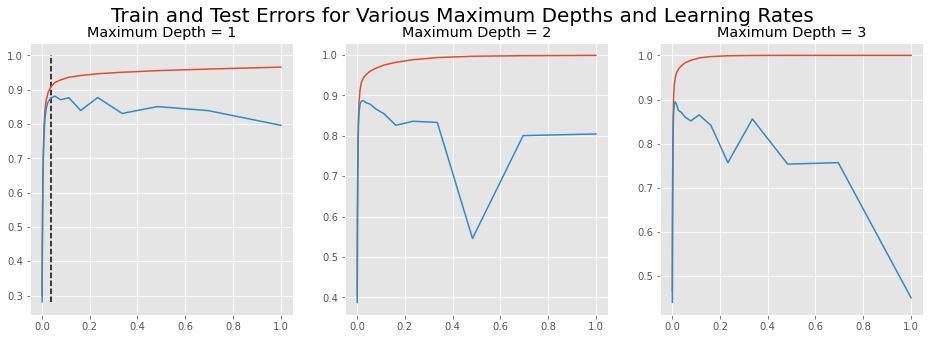

In [655]:
fig, axs = plt.subplots(1, 3, figsize = (16,5))
fig.suptitle('Train and Test Errors for Various Maximum Depths and Learning Rates', fontsize = 20)
axs[0].plot(learning_rates, train_scores)
axs[0].plot(learning_rates, test_scores)
axs[0].vlines(0.037927, 0.28, 1, linestyles = 'dashed')
axs[0].set_title('Maximum Depth = 1')
axs[1].plot(learning_rates, train_scores2)
axs[1].plot(learning_rates, test_scores2)
axs[1].set_title('Maximum Depth = 2')
axs[2].plot(learning_rates, train_scores3)
axs[2].plot(learning_rates, test_scores3)
axs[2].set_title('Maximum Depth = 3')

In [634]:
# Get good balance between test/train score at learning_rate = 0.037927, max_depth = 1

gbr.set_params(n_estimators = 500, learning_rate = 0.037927, max_depth = 1)

GradientBoostingRegressor(learning_rate=0.037927, max_depth=1, n_estimators=500)

In [635]:
gbr.fit(X_train_gbr, y_train)
print(gbr.score(X_train_gbr, y_train))
print(gbr.score(X_test_gbr, y_test))

0.9088261500531853
0.876197256007496


In [191]:
# Feature importances 

sorted(list(zip(X_train_gbr.columns, gbr.feature_importances_)), key = lambda x: -x[1])

[('OverallQual', 0.5630903816833007),
 ('GrLivArea', 0.1367042475194275),
 ('TotalBsmtSF', 0.050941770258901516),
 ('CentralAir', 0.028356006487864543),
 ('BsmtFinSF1', 0.02341676746019219),
 ('LotArea', 0.023390115075020045),
 ('GarageCars', 0.02025543928966084),
 ('X1stFlrSF', 0.016138740399424256),
 ('GarageArea', 0.013411763523542989),
 ('YearRemodAdd', 0.010619822021695466),
 ('YearBuilt', 0.009678757930284986),
 ('LotFrontage', 0.007869721155216924),
 ('Neighborhood', 0.0074544265459815275),
 ('BsmtUnfSF', 0.006420225566737275),
 ('MoSold', 0.005902676667514271),
 ('OverallCond', 0.005735258522620031),
 ('OpenPorchSF', 0.005646420866709839),
 ('BsmtExposure', 0.004948871704524023),
 ('MasVnrArea', 0.004174382438034297),
 ('Functional', 0.0037751661869940677),
 ('HouseStyle', 0.003266480813601731),
 ('TotRmsAbvGrd', 0.003264658819777934),
 ('WoodDeckSF', 0.0027187502440389876),
 ('BsmtQual', 0.0027124835641009182),
 ('GarageType', 0.0027060981154375372),
 ('BsmtFinType1', 0.002624

In [637]:
test_data_gbr = pd.read_csv('test_final.csv').drop('Unnamed: 0', axis = 1)
test_data_gbr = numer_label(test_data_gbr)
test_data_gbr

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  \
0             20         2           80    11622       1         3   
1             20         3           81    14267       1         0   
2             60         3           74    13830       1         0   
3             60         3           78     9978       1         0   
4            120         3           43     5005       1         0   
...          ...       ...          ...      ...     ...       ...   
1454         160         4           21     1936       1         3   
1455         160         4           21     1894       1         3   
1456          20         3          160    20000       1         3   
1457          85         3           62    10441       1         3   
1458          60         3           74     9627       1         3   

      LandContour  Utilities  LotConfig  LandSlope  ...  WoodDeckSF  \
0               3          0          4          0  ...         140   
1               3          0          0          0  ...         393   
2               3          0          4          0  ...         212   
3               3          0          4          0  ...         360   
4               1          0          4          0  ...           0   
...           ...        ...        ...        ...  ...         ...   
1454            3          0          4          0  ...           0   
1455            3          0          4          0  ...           0   
1456            3          0          4          0  ...         474   
1457            3          0          4          0  ...          80   
1458            3          0          4          1  ...         190   

      OpenPorchSF  EnclosedPorch  X3SsnPorch  ScreenPorch  MiscVal  MoSold  \
0               0              0           0          120        0       6   
1              36              0           0            0    12500       6   
2              34              0           0            0        0       3   
3              36              0           0            0        0       6   
4              82              0           0          144        0       1   
...           ...            ...         ...          ...      ...     ...   
1454            0              0           0            0        0       6   
1455           24              0           0            0        0       4   
1456            0              0           0            0        0       9   
1457           32              0           0            0      700       7   
1458           48              0           0            0        0      11   

      YrSold  SaleType  SaleCondition  
0       2010         8              4  
1       2010         8              4  
2       2010         8              4  
3       2010         8              4  
4       2010         8              4  
...      ...       ...            ...  
1454    2006         8              4  
1455    2006         8              0  
1456    2006         8              0  
1457    2006         8              4  
1458    2006         8              4  

[1459 rows x 73 columns]

In [640]:
predictions = pd.DataFrame({'Id': np.arange(1461, 2920), 'SalePrice': np.e**gbr.predict(test_data_gbr)})
predictions.to_csv('predictions.csv', index = False)
# get Kaggle score of 0.14420 #Nearly identical to best elastic-net

ELASTIC NET REGRESSION:

In [546]:
X2 = X.copy()
X2['MSSubClass'] = X2['MSSubClass'].astype('str')

0       60
1       20
2       60
3       70
4       60
        ..
1455    60
1456    20
1457    70
1458    20
1459    20
Name: MSSubClass, Length: 1460, dtype: object

In [547]:
X_dum = pd.get_dummies(X2)
X_train_dum, X_test_dum, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, random_state=42)

In [550]:
# Cross-validation for elastic net regression

param_grid = {'alpha': np.linspace(.0001, .0101, 101), 'l1_ratio': np.linspace(.01, 1, 100)}
enet = ElasticNet(normalize = True, max_iter = 100000)
gs2 = GridSearchCV(estimator = enet, param_grid = param_grid, cv = 5, scoring = 'r2')
gs2.fit(X_train_dum, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000, normalize=True),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='r2')

In [551]:
enet_best = gs2.best_estimator_
enet_best

ElasticNet(alpha=0.0005, l1_ratio=0.09999999999999999, max_iter=100000,
           normalize=True)

In [552]:
print(enet_best.score(X_train_dum, y_train))
print(enet_best.score(X_test_dum, y_test))

0.9221600860482138
0.9032843187821276


In [553]:
test_data = pd.read_csv('test_final.csv').drop('Unnamed: 0', axis = 1)
test_data['MSSubClass'] = test_data['MSSubClass'].astype('str')
test_data = pd.get_dummies(test_data)
test_data # problem: fewer columns in dummified test_data
          # refit lasso regression using only columns that appear in test_data

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0              80    11622            5            6       1961          1961   
1              81    14267            6            6       1958          1958   
2              74    13830            5            5       1997          1998   
3              78     9978            6            6       1998          1998   
4              43     5005            8            5       1992          1992   
...           ...      ...          ...          ...        ...           ...   
1454           21     1936            4            7       1970          1970   
1455           21     1894            4            5       1970          1970   
1456          160    20000            5            7       1960          1996   
1457           62    10441            5            5       1992          1992   
1458           74     9627            7            5       1993          1994   

      MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLw  \
0              0         468         144        270  ...               0   
1            108         923           0        406  ...               0   
2              0         791           0        137  ...               0   
3             20         602           0        324  ...               0   
4              0         263           0       1017  ...               0   
...          ...         ...         ...        ...  ...             ...   
1454           0           0           0        546  ...               0   
1455           0         252           0        294  ...               0   
1456           0        1224           0          0  ...               0   
1457           0         337           0        575  ...               0   
1458          94         758           0        238  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      0   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
1454             0             0            1                      0   
1455             0             0            1                      1   
1456             0             0            1                      1   
1457             0             0            1                      0   
1458             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1454                      0                     0                     0   
1455                      0                     0                     0   
1456                      0                     0                     0   
1457                      0                     0                     0   
1458                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        1                      0  
4                        1                      0  
...                    ...                

In [570]:
test_cols = list(filter(lambda x: x in test_data.columns, X_dum.columns))

In [554]:
param_grid = {'alpha': np.linspace(.0001, .0101, 101), 'l1_ratio': np.linspace(.01, 1, 100)}
enet = ElasticNet(normalize = True, max_iter = 100000)
gs3 = GridSearchCV(estimator = enet, param_grid = param_grid, cv = 5, scoring = 'r2')
gs3.fit(X_train_dum[test_cols], y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000, normalize=True),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='r2')

In [555]:
enet_best = gs3.best_estimator_
# heavily weighted toward ridge error term

In [615]:
enet_best

ElasticNet(alpha=0.0005, l1_ratio=0.09999999999999999, max_iter=100000,
           normalize=True)

In [573]:
enet_best.fit(X_train_dum[test_cols], y_train)

print(enet_best.score(X_train_dum[test_cols], y_train))
print(enet_best.score(X_test_dum[test_cols], y_test))

# No evidence of overfitting

0.9098788152973035
0.8982476873018609


In [578]:
train_cols = test_cols = list(filter(lambda x: x in X_dum.columns, test_data.columns))

test_data = test_data[train_cols]
test_data.shape

(1459, 281)

In [579]:
np.e**enet_best.predict(test_data)

array([120197.06977955, 150655.03905792, 178403.07441441, ...,
       162526.33626524, 116460.45485459, 216834.04951433])

In [580]:
predictions_enet = pd.DataFrame({'Id': np.arange(1461, 2920), 'SalePrice': np.e**enet_best.predict(test_data)})
predictions_enet.to_csv('predictions_enet.csv', index = False) 
# Kaggle score improved to 0.14258 (position 2237)

In [581]:
# another elastic net regression, using only predictors with VIF < 10

AC = add_constant(X_train_dum[test_cols])
VIFs = pd.Series([variance_inflation_factor(AC.values, i) for i in range(AC.shape[1])], index=AC.columns)
VIFs = VIFs.sort_values()
VIFs = VIFs[(VIFs.index != 'const') & (VIFs < 10)]
VIFs

/Users/nick/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/nick/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


X3SsnPorch             1.243746
MoSold                 1.267902
MiscVal                1.366032
YrSold                 1.385890
ScreenPorch            1.409024
BsmtHalfBath           1.552973
WoodDeckSF             1.672865
Utilities_AllPub       1.706644
OpenPorchSF            1.754632
EnclosedPorch          1.770963
Condition2_PosN        2.575395
OverallCond            2.694675
Condition2_PosA        2.709211
Exterior1st_AsphShn    2.927634
BsmtFullBath           3.092310
LotFrontage            3.156885
HalfBath               3.175204
MasVnrArea             3.384377
Condition2_Feedr       3.528696
Condition2_Artery      3.829511
BedroomAbvGr           3.856656
RoofMatl_WdShake       3.884892
Heating_Wall           3.885067
YearRemodAdd           3.910315
FullBath               4.384248
RoofMatl_WdShngl       4.457005
Heating_Grav           4.566768
Exterior1st_BrkComm    4.597171
LotArea                4.634185
KitchenAbvGr           5.276255
Exterior2nd_Stone      5.441584
OverallQ

In [590]:
VIFs.shape

(43,)

Text(0.5, 1.0, 'Ten Lowest Variance Inflation Factors')

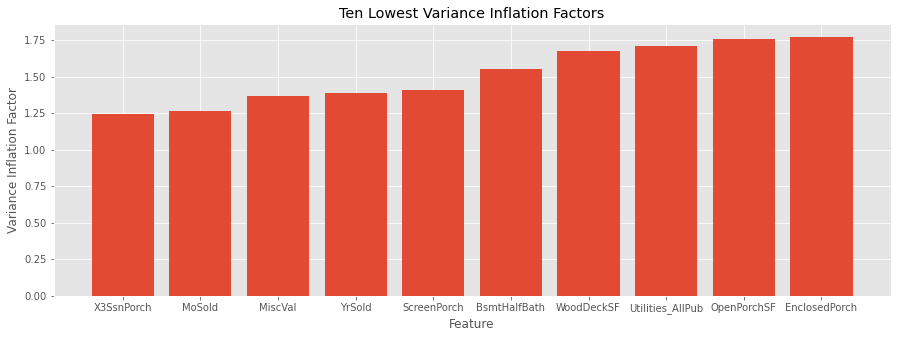

In [583]:
plt.figure(figsize = (15,5))
plt.bar(VIFs.index[:10], VIFs.values[:10])
plt.xlabel('Feature')
plt.ylabel('Variance Inflation Factor')
plt.title('Ten Lowest Variance Inflation Factors')

In [588]:
VIF_cols = VIFs.index

In [591]:
param_grid = {'alpha': np.linspace(.0001, .0101, 101), 'l1_ratio': np.linspace(.01, 1, 100)}
enet = ElasticNet(normalize = True, max_iter = 100000)
gs4 = GridSearchCV(estimator = enet, param_grid = param_grid, cv = 5, scoring = 'r2')
gs4.fit(X_train_dum[VIF_cols], y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000, normalize=True),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='r2')

In [617]:
vif_best = gs4.best_estimator_
vif_best

# heavily weighted toward lasso error term

ElasticNet(alpha=0.00030000000000000003, l1_ratio=0.85, max_iter=100000,
           normalize=True)

In [618]:
vif_best.fit(X_train_dum[VIF_cols], y_train)

print(vif_best.score(X_train_dum[VIF_cols], y_train))
print(vif_best.score(X_test_dum[VIF_cols], y_test))

# Still no evidence overfitting, but lower accuracy

0.8340654623556347
0.832998748887781


In [619]:
predictions_vif = pd.DataFrame({'Id': np.arange(1461, 2920),
                                'SalePrice': np.e**vif_best.predict(test_data[VIF_cols])})
predictions_vif.to_csv('predictions_vif.csv', index = False)
# Score not drastically worse, despite overfitting 0.16239

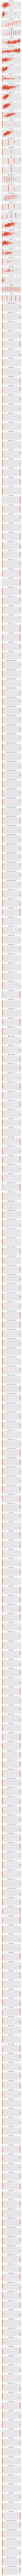

In [599]:
# Examining scatterplots of each predictor against target

X_partial = X_train_dum[test_cols]

fig, axs = plt.subplots(X_partial.columns.shape[0], figsize = (6, 800))
for i in range(X_partial.columns.shape[0]):
    axs[i].scatter(x = X_partial[X_partial.columns[i]], y = y_train)
    axs[i].set_title(X_partial.columns[i])

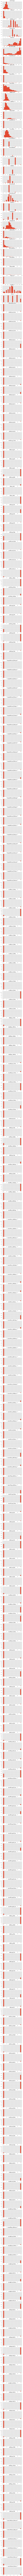

In [600]:
# Examining distribution of each predictor

fig, axs = plt.subplots(X_partial.columns.shape[0], figsize = (6, 800))
for i in range(X_partial.columns.shape[0]):
    axs[i].hist(x = X_partial[X_partial.columns[i]], bins = 20)
    axs[i].set_title(X_partial.columns[i])

In [605]:
# Manually selecting columns that display an approximately linear relationship with predictor
# or an approximately normal distribution (up to transformation)

X_manual_cols = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                   'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd',
                   'GarageCars', 'GarageArea', 'FullBath', 'Fireplaces', 'MoSold', 'LotShape_Reg',
                   'LotConfig_Inside', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
                   'HouseStyle_1Story', 'HouseStyle_2Story', 'RoofStyle_Gable', 'RoofStyle_Hip',
                   'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'Foundation_PConc',
                   'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_None', 'BsmtExposure_None',
                   'HeatingQC_Ex', 'HeatingQC_Fa', 'CentralAir_N', 'CentralAir_Y',
                   'KitchenQual_Ex', 'GarageType_None', 'FireplaceQu_None', 'MSSubClass_30',
                   'MSSubClass_60']

In [606]:
def transform(DF):
    '''
    Restrict data frame to X_manual_cols
    '''
    DF = DF[X_manual_cols].copy()
    DF['LotFrontage'] = DF['LotFrontage']**.5
    DF['LotArea'] = np.log(DF['LotFrontage'])
    DF['TotalBsmtSF'] = DF['TotalBsmtSF']**.5
    DF['GrLivArea'] = np.log(DF['GrLivArea'])
    
    return DF

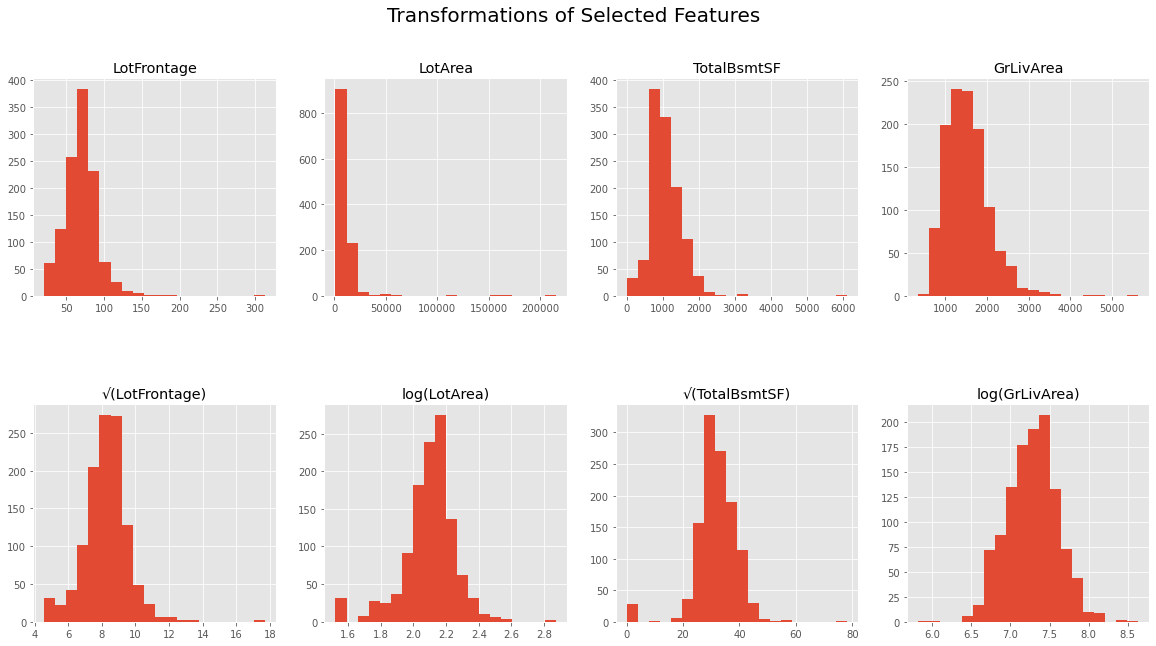

In [537]:
fig, axs = plt.subplots(2, 4, figsize = (20,10))
fig.suptitle('Transformations of Selected Features', fontsize = 20)
axs[0,0].hist(X_train_dum['LotFrontage'], bins = 20)
axs[0,0].set_title('LotFrontage')
axs[1,0].hist(X_manual['LotFrontage'], bins = 20)
axs[1,0].set_title('√(LotFrontage)')
axs[0,1].hist(X_train_dum['LotArea'], bins = 20)
axs[0,1].set_title('LotArea')
axs[1,1].hist(X_manual['LotArea'], bins = 20)
axs[1,1].set_title('log(LotArea)')
axs[0,2].hist(X_train_dum['TotalBsmtSF'], bins = 20)
axs[0,2].set_title('TotalBsmtSF')
axs[1,2].hist(X_manual['TotalBsmtSF'], bins = 20)
axs[1,2].set_title('√(TotalBsmtSF)')
axs[0,3].hist(X_train_dum['GrLivArea'], bins = 20)
axs[0,3].set_title('GrLivArea')
axs[1,3].hist(X_manual['GrLivArea'], bins = 20)
axs[1,3].set_title('log(GrLivArea)')
plt.subplots_adjust(hspace=.5)

# Features that were transformed in manual selection

(array([  2.,   0.,   1.,   0.,  16.,   0.,  88.,   0., 308.,   0.,   0.,
        311.,   0., 258.,   0., 135.,   0.,  36.,   0.,  13.]),
 array([ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ]),
 <a list of 20 Patch objects>)

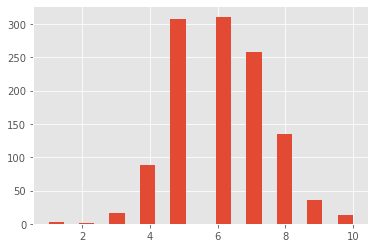

In [485]:
plt.hist(X_train_dum['OverallQual'], bins = 20)

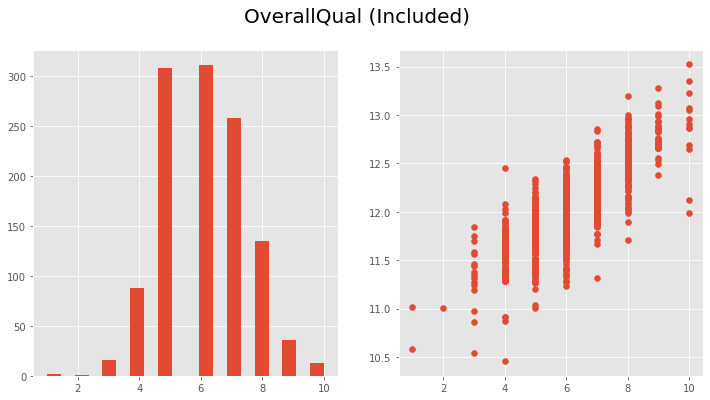

In [509]:
fig, axs = plt.subplots(1,2, figsize = (12,6))
fig.suptitle('OverallQual (Included)', fontsize = 20)
axs[0].hist(X_train_dum['OverallQual'], bins = 20)
axs[1].scatter(X_train_dum['OverallQual'], y_train)

# example: a feature that was selected

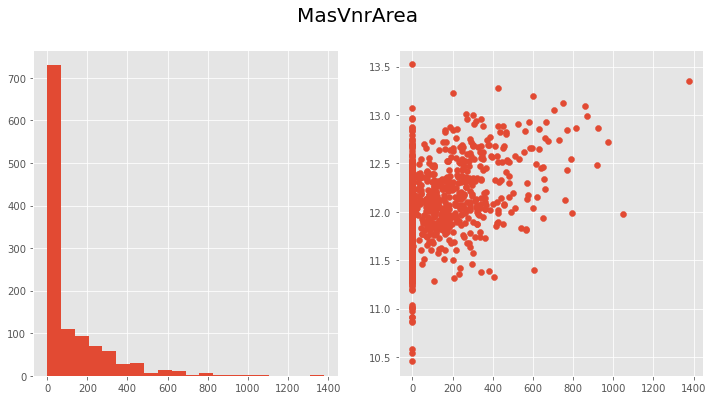

In [541]:
fig, axs = plt.subplots(1,2, figsize = (12,6))
fig.suptitle('MasVnrArea', fontsize = 20)
axs[0].hist(X_train_dum['MasVnrArea'], bins = 20)
axs[1].scatter(X_train_dum['MasVnrArea'], y_train)

# example: a feature that was not selected

In [607]:
X_manual = transform(X_train_dum)
X_manual_test = transform(X_test_dum)

In [614]:
X_manual.shape

(1168, 38)

In [609]:
param_grid = {'alpha': np.linspace(.0001, .0101, 101), 'l1_ratio': np.linspace(.01, 1, 100)}
enet = ElasticNet(normalize = True, max_iter = 100000)
gs4 = GridSearchCV(estimator = enet, param_grid = param_grid, cv = 5, scoring = 'r2')
gs4.fit(X_manual, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000, normalize=True),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='r2')

In [610]:
manual_best = gs4.best_estimator_
manual_best

ElasticNet(alpha=0.0001, l1_ratio=0.53, max_iter=100000, normalize=True)

In [611]:
print(manual_best.score(X_manual, y_train))
print(manual_best.score(X_manual_test, y_test)) # No evidence of overfitting.
                                                # Small improvement over restricing columns by VIF.
                                                # Not clear whether improvement is significant.

0.8621828075469274
0.875636961539451


In [612]:
test_manual = transform(test_data)
manual_best.predict(test_manual)

array([11.69769779, 11.92154928, 12.07605569, ..., 12.02259544,
       11.55872554, 12.35114365])

In [613]:
predictions_manual = pd.DataFrame({'Id': np.arange(1461, 2920), 'SalePrice': np.e**manual_best.predict(test_manual)})
predictions_manual.to_csv('predictions_manual.csv', index = False)
# Kaggle score 0.14950
# Improvement on feature selection by VIF, but elastic net with all predictors still best.

Lasso feature importances:

In [383]:
X_train_dum
lasso = Lasso()
alphas = np.linspace(.0001, .0101, 101)
coefs = []
for alpha in alphas:
    lasso.set_params(alpha = alpha)
    lasso.fit(X_train_dum, y_train)
    coefs.append(lasso.coef_)
    
# get coefficients for each feature at values of alpha from .0001 to .1001

(0.0, 0.002)

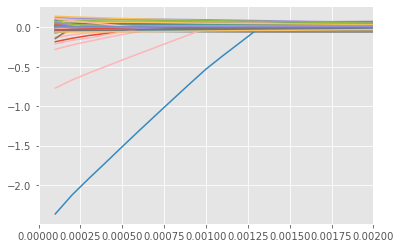

In [385]:
coefs_df = pd.DataFrame(np.array(coefs), columns = X_train_dum.columns)
for name in xxxx.columns:
    plt.plot(alphas, coefs_df[name])
plt.xlim(0, .002)

In [386]:
coefs_df

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0     -0.000275     0.000144  0.000001     0.045169     0.036395   0.001716   
1     -0.000236     0.000063  0.000001     0.048523     0.037716   0.001686   
2     -0.000234    -0.000017  0.000001     0.051229     0.039080   0.001664   
3     -0.000303    -0.000091  0.000001     0.053174     0.039868   0.001710   
4     -0.000370    -0.000170  0.000001     0.054931     0.040535   0.001741   
..          ...          ...       ...          ...          ...        ...   
96    -0.000804    -0.000737  0.000002     0.082088     0.034092   0.003195   
97    -0.000804    -0.000736  0.000002     0.082001     0.033995   0.003193   
98    -0.000804    -0.000734  0.000002     0.081913     0.033898   0.003192   
99    -0.000804    -0.000733  0.000002     0.081825     0.033801   0.003190   
100   -0.000805    -0.000732  0.000002     0.081737     0.033704   0.003189   

     YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0        0.001141    0.000023    0.000095    0.000096  ...            -0.0   
1        0.001118    0.000017    0.000085    0.000096  ...            -0.0   
2        0.001101    0.000012    0.000075    0.000090  ...            -0.0   
3        0.001088    0.000007    0.000065    0.000084  ...            -0.0   
4        0.001079    0.000004    0.000055    0.000078  ...            -0.0   
..            ...         ...         ...         ...  ...             ...   
96       0.001785   -0.000008    0.000072    0.000054  ...            -0.0   
97       0.001787   -0.000008    0.000072    0.000054  ...            -0.0   
98       0.001790   -0.000008    0.000072    0.000054  ...            -0.0   
99       0.001793   -0.000008    0.000072    0.000054  ...            -0.0   
100      0.001796   -0.000008    0.000072    0.000054  ...            -0.0   

     SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0.0      0.072425    -0.044355              -0.060610   
1             0.0      0.010521    -0.043795              -0.059796   
2             0.0      0.000000    -0.042668              -0.058812   
3             0.0      0.000000    -0.040137              -0.057564   
4             0.0      0.000000    -0.036420              -0.056466   
..            ...           ...          ...                    ...   
96            0.0      0.000000    -0.000000              -0.000000   
97            0.0      0.000000    -0.000000              -0.000000   
98            0.0      0.000000    -0.000000              -0.000000   
99            0.0      0.000000    -0.000000              -0.000000   
100           0.0      0.000000    -0.000000              -0.000000   

     SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0.0              0.112446             -0.032293   
1                      0.0              0.082492             -0.028472   
2                      0.0              0.060060             -0.022226   
3                      0.0              0.038052             -0.014651   
4                      0.0              0.015313             -0.006796   
..                     ...                   ...                   ...   
96                     0.0              0.000000             -0.000000   
97                     0.0              0.000000             -0.000000   
98                     0.0              0.000000             -0.000000   
99                     0.0              0.000000             -0.000000   
100                    0.0              0.000000             -0.000000   

     SaleCondition_Normal  SaleCondition_Partial  
0                     0.0                    0.0  
1                     0.0                    0.0  
2                     0.0                    0.0  
3                     0.0                    0.0  
4                    -0.0                    0.0  
..                    ...                    ...  
96                  

In [387]:
last_nonzero = []
for name in coefs_df.columns:
    nonzero_coef = coefs_df[name] > 0
    if nonzero_coef.sum() > 0:
        last = coefs_df[name][nonzero_coef].index[-1]
        last_nonzero.append(last)
    else:
        last = -1
    
sorted(list(zip(coefs_df.columns, last_nonzero)), key = lambda x: -x[1])

# 100 indicates that feature's coefficient has not yet reached 0.

# There is some overlap between these features and those obtained
# by examining gradient boosting feature importances.

[('LotFrontage', 100),
 ('LotArea', 100),
 ('OverallQual', 100),
 ('OverallCond', 100),
 ('YearBuilt', 100),
 ('MasVnrArea', 100),
 ('BsmtFinSF1', 100),
 ('BsmtFinSF2', 100),
 ('BsmtUnfSF', 100),
 ('TotalBsmtSF', 100),
 ('X1stFlrSF', 100),
 ('X2ndFlrSF', 100),
 ('LowQualFinSF', 100),
 ('BedroomAbvGr', 100),
 ('KitchenAbvGr', 100),
 ('Fireplaces', 100),
 ('GarageCars', 100),
 ('WoodDeckSF', 100),
 ('OpenPorchSF', 100),
 ('EnclosedPorch', 100),
 ('TotRmsAbvGrd', 93),
 ('GrLivArea', 91),
 ('LotConfig_Corner', 73),
 ('X3SsnPorch', 71),
 ('BldgType_1Fam', 69),
 ('BldgType_Duplex', 67),
 ('Condition1_RRNe', 66),
 ('Neighborhood_Sawyer', 60),
 ('Condition1_Norm', 45),
 ('LotShape_IR2', 44),
 ('Condition2_RRNn', 43),
 ('Neighborhood_SawyerW', 41),
 ('Neighborhood_StoneBr', 37),
 ('LandContour_Bnk', 34),
 ('Neighborhood_CollgCr', 34),
 ('Neighborhood_Veenker', 32),
 ('Condition2_Artery', 29),
 ('Condition2_PosA', 27),
 ('RoofStyle_Gable', 26),
 ('HalfBath', 25),
 ('Condition1_PosN', 25),
 ('MSZ

Scatterplots for important features in train set and in predictions for first elastic net regression

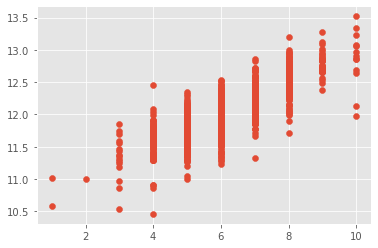

In [388]:
plt.scatter(X_train_dum['OverallQual'], y_train)

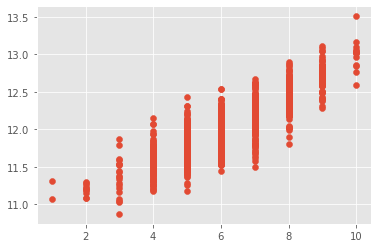

In [389]:
plt.scatter(test_data['OverallQual'], enet_best.predict(test_data))
# nearly same shape

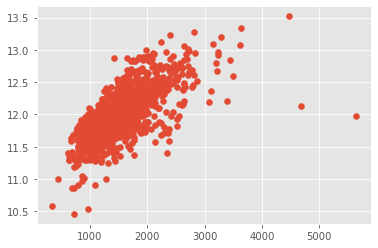

In [392]:
plt.scatter(X_train_dum['GrLivArea'], y_train)

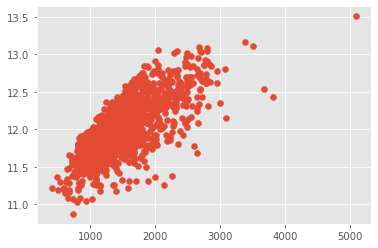

In [393]:
plt.scatter(test_data['GrLivArea'], enet_best.predict(test_data))
#Very similar again

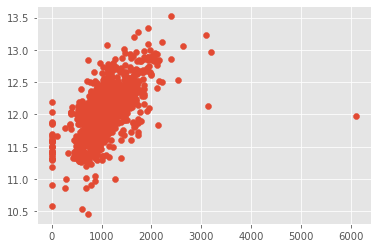

In [394]:
plt.scatter(X_train_dum['TotalBsmtSF'], y_train)

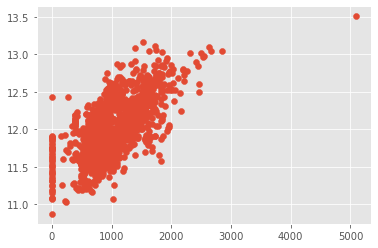

In [395]:
plt.scatter(test_data['TotalBsmtSF'], enet_best.predict(test_data))

#Again, quite consistent

In [476]:
homes.groupby('YrSold')['SalePrice'].median()

YrSold
2006    163995
2007    167000
2008    164000
2009    162000
2010    155000
Name: SalePrice, dtype: int64

In [543]:
homes['MSSubClass'].astype('str')

0       60
1       20
2       60
3       70
4       60
        ..
1455    60
1456    20
1457    70
1458    20
1459    20
Name: MSSubClass, Length: 1460, dtype: object